# Predicting Physician Specialty from CMS Medicare Drug Prescription Data

The Medicare Part D Prescribers - by Provider and Drug dataset includes data for providers that had a valid NPI and were identified on Medicare Part D prescription drug events submitted by plans for the benefit year. The data reflect prescribing to beneficiaries enrolled in Medicare Part D, who comprise approximately 70% of the total Medicare population.

Each record in the dataset represents a distinct combination of NPI, drug (brand) name, and generic name. There can be multiple records for a given NPI based on the number of distinct drugs that were filled. For each prescriber and drug, the dataset includes the total number of prescriptions that were dispensed (including original prescriptions and any refills), total 30-day standardized fill counts, total day’s supply for these prescriptions, and the total drug cost. 

## Data Dictionary

| Term Name      | Variable Name |  Description  |  |
| ----------- | ----------- || ----------- |
| Prescriber NPI      | Prscrbr_NPI       | National Provider Identifier (NPI) for the performing provider on the claim.
| Prescriber Last Name / Organization Name | Prscrbr_Last_Org_Name|When the provider is registered in NPPES as an individual (Prscrbr_Ent_Cd = “I”), this is the provider’s last name. When the provider is registered as an organization (Prscrbr_Ent_Cd = “O”), this is the organization name.
| Prescriber First Name   | Prscrbr_First_Name  |When the provider is registered in NPPES as an individual (Prscrbr_Ent_Cd = “I”), this is the provider’s first name. When the provider is registered as an organization (Prscrbr_Ent_Cd = “O”), this will be blank.
| Prescriber City   | Prscrbr_City | The city where the provider is located, as reported in NPPES.
| Prescriber State   | Prscrbr_State_Abrvtn   |The state where the provider is located, as reported in NPPES. The fifty U.S. states and the District of Columbia are reported by the state postal abbreviation.
| Prescriber State FIPS Code   | Prscrbr_State_FIPS |FIPS code for referring providers state.
| Provider Specialty Type   | Prscrbr_Type | Derived from the Medicare provider/supplier specialty code reported on the NPI’s Part B claims. For providers that have more than one Medicare specialty code reported on their claims, the Medicare specialty code associated with the largest number of services is reported.
| Source of Provider Specialty   | Prscrbr_Type_Src |A flag that indicates the source of the Prscrbr_Type.
| Brand Name   | Brnd_Name |Brand name (trademarked name) of the drug filled.
| USAN Generic Name - Short Version  | Gnrc_Name |A term referring to the chemical ingredient of a drug rather than the trademarked brand name under which the drug is sold.
| Number of Medicare Part D Claims, Including Refills   | Tot_Clms    |The number of Medicare Part D claims. This includes original prescriptions and refills.
| Number of Standardized 30-Day Fills, Including Refills   | Tot_30day_Fills    |The aggregate number of Medicare Part D standardized 30-day fills. The standardized 30-day fill is derived from the number of days supplied on each Part D claim divided by 30.
| Number of Day’s Supply for All Claims | Tot_Day_Suply        |The aggregate number of day’s supply for which this drug was dispensed.
| Aggregate Cost Paid for All Claims   | Tot_Drug_Cst  |The aggregate drug cost paid for all associated claims. This amount includes ingredient cost, dispensing fee, sales tax, and any applicable vaccine administration fees and is based on the amounts paid by the Part D plan, Medicare beneficiary, government subsidies, and any other third-party payers.v
| Number of Medicare Beneficiaries   | Tot_Benes |The total number of unique Medicare Part D beneficiaries with at least one claim for the drug.
| Reason for Suppression of GE65_Tot_Clms, GE65_Tot_30day_Fills, GE65_Tot_Drug_Cst and GE65_Tot_Day_Suply   | GE65_Sprsn_Flag |A flag that indicates the reason the GE65_Tot_Clms, GE65_Tot_30day_Fills, GE65_Tot_Drug_Cst and GE65_Tot_Day_Suply variables are suppressed
| Number of Claims, Including Refills, for Beneficiaries Age 65+   | GE65_Tot_Clms        |The number of Medicare Part D claims for beneficiaries age 65 and older. This includes original prescriptions and refills.
| Number of Standardized 30-Day Fills, Including Refills, for Beneficiaries Age 65+   | GE65_Tot_30day_Fills  |The number of Medicare Part D standardized 30-day fills for beneficiaries age 65 and older. The standardized 30-day fill is derived from the number of days supplied on each Part D claim divided by 30.
| Aggregate Cost Paid for All Claims for Beneficiaries Age 65+   | GE65_Tot_Drug_Cst  |The aggregate total drug cost paid for all associated claims for beneficiaries age 65 and older. This amount includes ingredient cost, dispensing fee, sales tax, and any applicable vaccine administration fees and is based on the amounts paid by the Part D plan, Medicare beneficiary, government subsidies, and any other third-party payers.
| Number of Day’s Supply for All Claims for Beneficaries Age 65+   | GE65_Tot_Day_Suply       |The aggregate number of day’s supply for which this drug was dispensed, for beneficiaries age 65 and older. 
| Reason for Suppression of GE65_Tot_Benes   | GE65_Bene_Sprsn_Flag |A flag indicating the reason the GE65_Tot_Benes variable is suppressed.
| Number of Medicare Beneficiaries Age 65+   | GE65_Tot_Benes        |The total number of unique Medicare Part D beneficiaries age 65 and older with at least one claim for the drug.

In [35]:
%%capture

#Verify conda environment
import os
print (os.environ['CONDA_DEFAULT_ENV'])

!pip install fastparquet
!pip install pyarrow
!pip install plotly-geo
!pip install geopandas
!pip install pyshp
!pip install shapely
!pip install dataframe_image

#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

os.chdir('../data')

In [2]:
!conda env list

# conda environments:
#
base                     /Users/francescaabulencia/opt/anaconda3
aimsinput                /Users/francescaabulencia/opt/anaconda3/envs/aimsinput
data1030              *  /Users/francescaabulencia/opt/anaconda3/envs/data1030
pytorch                  /Users/francescaabulencia/opt/anaconda3/envs/pytorch
pytorchenv               /Users/francescaabulencia/opt/anaconda3/envs/pytorchenv
test                     /Users/francescaabulencia/opt/anaconda3/envs/test
                         /opt/miniconda3



## Loading the Dataset

Sources:  
[1] https://data.cms.gov/provider-summary-by-type-of-service/medicare-part-d-prescribers/medicare-part-d-prescribers-by-provider-and-drug    
[2] https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider-and-service  
[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7358033/#b20-0180334  
[4] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9507660/

### Converting .gzip to .parquet file type


In [ ]:
%%time

filename = 'MUP_DPR_RY22_P04_V10_DY20_NPIBN.csv.gz'
gzip_file = pd.read_csv(filename, compression='gzip', encoding = 'latin-1', low_memory=False)

In [ ]:
gzip_file.to_parquet('df.parquet', compression='snappy')

In [163]:
%%time

df = pd.read_parquet('df.parquet', engine='fastparquet')

FileNotFoundError: [Errno 2] No such file or directory: 'df.parquet'

**By converting gzip to csv, the time to read the ~25 million rows improved from 15 min to 15 seconds**

## I. Exploratory Data Analysis

In [164]:
df.head(5)

,Prscrbr_NPI,Prscrbr_Last_Org_Name,Prscrbr_First_Name,Prscrbr_City,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,Prscrbr_Type,Prscrbr_Type_Src,Brnd_Name,Gnrc_Name,...,Tot_Day_Suply,Tot_Drug_Cst,Tot_Benes,GE65_Sprsn_Flag,GE65_Tot_Clms,GE65_Tot_30day_Fills,GE65_Tot_Drug_Cst,GE65_Tot_Day_Suply,GE65_Bene_Sprsn_Flag,GE65_Tot_Benes
0,1003000126,Enkeshafi,Ardalan,Bethesda,MD,24,Internal Medicine,S,Amiodarone Hcl,Amiodarone Hcl,...,399,135.38,NaN,None,13.0,13.8,135.38,399.0,*,NaN
1,1003000126,Enkeshafi,Ardalan,Bethesda,MD,24,Internal Medicine,S,Amlodipine Besylate,Amlodipine Besylate,...,570,42.47,NaN,*,NaN,NaN,NaN,NaN,*,NaN
2,1003000126,Enkeshafi,Ardalan,Bethesda,MD,24,Internal Medicine,S,Bumetanide,Bumetanide,...,540,494.38,NaN,None,16.0,18.0,494.38,540.0,*,NaN
3,1003000126,Enkeshafi,Ardalan,Bethesda,MD,24,Internal Medicine,S,Eliquis,Apixaban,...,323,4792.85,NaN,*,NaN,NaN,NaN,NaN,*,NaN
4,1003000126,Enkeshafi,Ardalan,Bethesda,MD,24,Internal Medicine,S,Hydralazine Hcl,Hydralazine Hcl,...,523,162.09,NaN,#,NaN,NaN,NaN,NaN,*,NaN


##### Orders of Magnitude for the Range of Continuous Variables


In [187]:
Min = pd.DataFrame(df.min())
Min = Min.iloc[5:,:]

Max = pd.DataFrame(df.max())
Max = Max.iloc[5:,:]

/var/folders/c5/tg08zzhd0tq1dsl0flngdj540000gn/T/ipykernel_2463/3104216207.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Min = pd.DataFrame(df.min())
/var/folders/c5/tg08zzhd0tq1dsl0flngdj540000gn/T/ipykernel_2463/3104216207.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Max = pd.DataFrame(df.max())


In [242]:
Range = pd.DataFrame(Max-Min)
Range[0] = pd.to_numeric(Range[0])
Range["Order of Magnitude for the Range"] = (np.log10(Range[0])).apply(np.floor)
Range = Range.drop([0], axis=1)
Range = Range.reset_index()
Range = Range.rename(columns={ Range.columns[0]: "Column" })

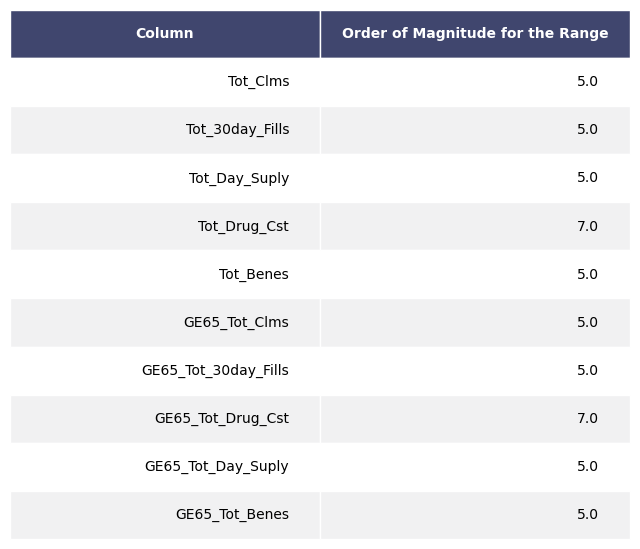

In [243]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=10,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(Range, header_columns=0, col_width=4.0)
fig.savefig("Table 2 - Order of Magnitude for the Range of Data.png", dpi = 1200)

#### Dimensions of the Raw Dataset

In [165]:
rows, columns = df.shape

print(f'Rows: {rows}')
print(f'Columns: {columns}')

Rows: 25209729
Columns: 22


#### Dropping Columns with Redundant or Unnecessary Information

| Variable Name      |  Reason  ||
| ------------------ | ---------------- ||
| Prscrbr_Last_Org_Name | info captured under NPI ||
| Prscrbr_First_Name | info captured under NPI ||
| Prscrbr_Type_Src | this is the source where info on provider specialty was acquired ||
| Prscrbr_State_FIPS | unique two digit code associated with the existing state column ||
| GE65_Sprsn_Flag | flag indicating why GE65_Tot_Clms, GE65_Tot_30day_Fills, <br>  GE65_Tot_Drug_Cst and GE65_Tot_Day_Suply are suppressed 	 ||
| GE65_Bene_Sprsn_Flag | flag indicating why GE65_Tot_Benes variable is suppressed ||

In [166]:
# Delete columns that identify prescriber first and last name since this data is captured in prescriber NPI

df = df.drop(columns=['Prscrbr_Last_Org_Name',
                      'Prscrbr_First_Name',
                      'Prscrbr_Type_Src',
                      'Prscrbr_State_FIPS',
                      'GE65_Sprsn_Flag', 
                      'GE65_Bene_Sprsn_Flag'])

##### Create Dataframe containing unique value counts

In [174]:
uniqueSpecialtyCount = len(df.Prscrbr_Type.unique())
uniqueNPICount = len(df.Prscrbr_NPI.unique())
uniqueBrndNameCount = len(df.Brnd_Name.unique())
uniqueGnrcNameCount = len(df.Gnrc_Name.unique())
uniqueCityCount = len(df.Prscrbr_City.unique())
uniqueStateCount = len(df.Prscrbr_State_Abrvtn.unique())

Vals = [uniqueSpecialtyCount, 
        uniqueNPICount,
        uniqueCityCount, 
        uniqueStateCount,
        uniqueBrndNameCount, 
        uniqueGnrcNameCount]

Cols = ["Specialty", "NPI", "Physician City", "Physician State", "Brand Name Drug", "Generic Drug"]

uniqueDf = pd.DataFrame([Cols, Vals]).T
uniqueDf.columns =['Column', 'Unique Counts']

In [175]:
uniqueDf.set_index('Column')

,Unique Counts
Column,
Specialty,184
NPI,983636
Physician City,12094
Physician State,62
Brand Name Drug,2990
Generic Drug,1723


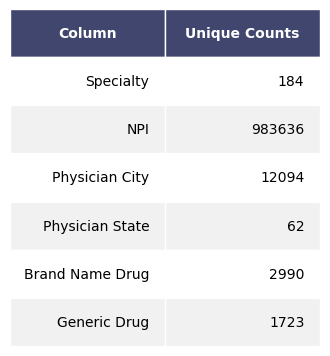

In [176]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=10,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(uniqueDf, header_columns=0, col_width=2.0)
fig.savefig("Table 1 - Unique Counts of Categorical Features.png", dpi = 1200)

#### Exploring the Target Variable

##### Provider Specialty Types

In [42]:
uniqueSpecialties = df.Prscrbr_Type.unique()

print(f'Number of Unique Specialties: {len(uniqueSpecialties)}')

SpecialtyByNPI = pd.DataFrame(df.groupby('Prscrbr_Type')['Prscrbr_NPI'].nunique())
SpecialtyByNPI.reset_index(inplace=True)
SpecialtyByNPI.columns = ['Prscrbr_Type', '# of NPIs']
SpecialtyByNPI = SpecialtyByNPI.sort_values(by=['# of NPIs'], ascending=False)

SpecialtyByNPI.head()

Number of Unique Specialties: 184


,Prscrbr_Type,# of NPIs
105,Nurse Practitioner,159441
74,Internal Medicine,100522
51,Family Practice,100509
38,Dentist,99779
136,Physician Assistant,84655


##### Exclude Physician Assistants (PAs), Nurse Practitioners (NPs), and Other Non-Physicians

In [43]:
#Excluding rows that are nonphysicians, physician assistants (PAs), nurse practitioners (NPs) acc. to paper

excludedSpecialties = ['Nurse Practitioner',
                       'Optometry',
                       'Physician Assistant',
                       'Student in an Organized Health Care Education/Training Program',
                       'Pharmacist',
                       'Certified Clinical Nurse Specialist',
                       'Specialist']


SpecialtyByNPI = SpecialtyByNPI[~SpecialtyByNPI.Prscrbr_Type.isin(excludedSpecialties)]

##### Include Specialties with > 5000 Providers

In [44]:
SpecialtyByNPI_HighFreq = SpecialtyByNPI[SpecialtyByNPI['# of NPIs'] > 5000]

SpecialtyByNPI_HighFreq.head()

,Prscrbr_Type,# of NPIs
74,Internal Medicine,100522
51,Family Practice,100509
38,Dentist,99779
46,Emergency Medicine,31845
106,Obstetrics & Gynecology,23356


In [45]:
print(f"Number of Specialties with > 5000 Physicians: {len(SpecialtyByNPI_HighFreq)}")
print()

# Include specialties that have > 5000 physicians and save to a new dataframe
SpecialtyByNPI_HighFreqList = list(SpecialtyByNPI_HighFreq.Prscrbr_Type)

df2 = df[df.Prscrbr_Type.isin(SpecialtyByNPI_HighFreqList)]

print(f'New dataframe dimension: {df2.shape}')
print()

rowsExcluded = df.shape[0]-df2.shape[0]
print(f'Rows excluded from raw dataset: {rowsExcluded}')

# delete original df to release memory
del df

Number of Specialties with > 5000 Physicians: 26

New dataframe dimension: (17972550, 16)

Rows excluded from raw dataset: 7237179


##### Plotting Frequency of Specialty by Number of Unique Provider

In [60]:
fig1_data = (df2.groupby('Prscrbr_Type')['Prscrbr_NPI'].nunique()/df2.groupby('Prscrbr_Type')['Prscrbr_NPI'].nunique().sum()).sort_values(ascending=True)

In [ ]:
plt.figure(figsize=(5,10))
fig1_data.plot.barh()
plt.xlabel('Frequency')
plt.ylabel('Provider Specialty Type')
plt.title('Frequency of Specialty by Number of Unique Provider',fontweight='bold')
plt.savefig('Figure 1 - Frequency of Specialy by Number of Unique NPI.png', dpi=1200,bbox_inches="tight")
plt.show()

#median drug price per specialty

##### Plotting Frequency of Specialty by Number of Unique Provider (Top 5 and Bottom 5)

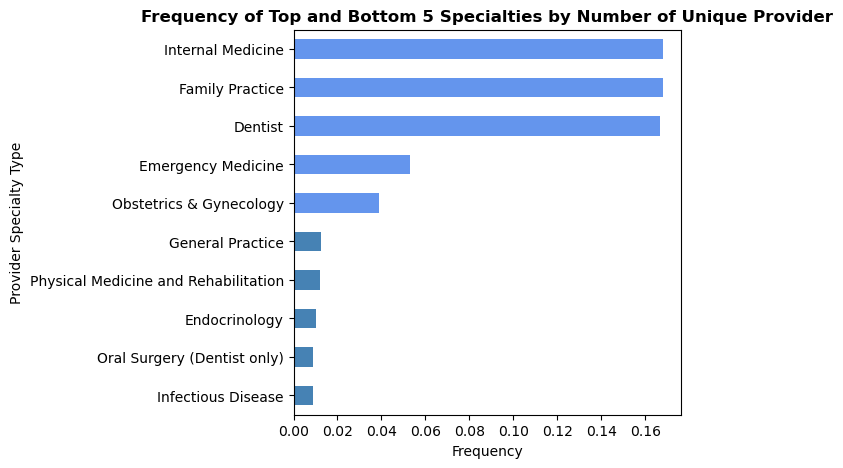

In [61]:

fig2_data = pd.concat([fig1_data.nlargest(5), fig1_data.nsmallest(5)]).sort_values(ascending=True)

plt.figure(figsize=(5,5))

c = ['steelblue','steelblue','steelblue','steelblue','steelblue',
    'cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue']

fig2_data.plot.barh(color = c)

plt.xlabel('Frequency')
plt.ylabel('Provider Specialty Type')
plt.title('Frequency of Top and Bottom 5 Specialties by Number of Unique Provider',fontweight='bold')
plt.savefig('Figure 2 - Frequency of Top and Bottom 5 Specialties by Number of Unique Provider.png', dpi=1200,bbox_inches="tight")
plt.show()

#median drug price per specialty

#### Fraction of Missing Values per Feature

In [151]:
missing_per_ftr = df2.isnull().sum(axis=0)/df2.shape[0]

#remove NPI & prescriber type since those will not be included in the feature matrix; one is needed for the group structure and the other is the target variable
fig3_data = missing_per_ftr.to_frame().reset_index()

fig3_data = fig3_data.drop([0, 3])

fig3_data = fig3_data.reset_index(drop=True)

plt.figure(figsize=(1,5))

y_axis_labels = fig3_data.iloc[:,0]
fig3_data = np.asarray(fig3_data.iloc[:,1]).reshape(14,1)
ax = sns.heatmap(fig3_data ,linewidth=0.5,yticklabels = y_axis_labels,cmap="viridis",vmin=0, vmax=1,annot=True)
plt.title("Fraction of Missing Values per Feature",fontweight='bold')
plt.savefig('Figure 3 - Fraction of Missing Values per Feature.png', dpi=1200,bbox_inches="tight")

plt.show()

#### Fraction of Rows with Missing Data

In [ ]:
missing = missing_per_ftr[missing_per_ftr > 0]
print (f'Fraction of Rows with Missing Data: {len(missing)/df2.shape[1]}')

#### Determining Categorical, Ordinal, and Continuous Features

In [ ]:
print(df2.dtypes)

In [129]:
target = ['Prscrbr_Type']

categorical_ftrs = ['Prscrbr_City',
                    'Prscrbr_State_Abrvtn',
                    'Brnd_Name',
                    'Gnrc_Name']

ordinal_ftrs = []

std_ftrs = ['Tot_Clms', 
            'Tot_30day_Fills', 
            'Tot_Day_Suply', 
            'Tot_Drug_Cst', 
            'Tot_Benes', 
            'GE65_Tot_Clms',
            'GE65_Tot_30day_Fills',
            'GE65_Tot_Drug_Cst',
            'GE65_Tot_Day_Suply',
            'GE65_Tot_Benes']

labelType = ["Categorical", "Continuous"]

28.57142984867096
71.42857313156128


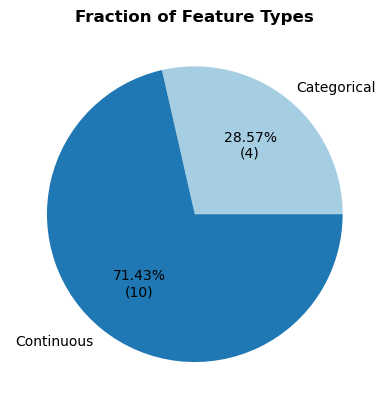

In [149]:
categoricalLen = len(categorical_ftrs)
continuousLen = len(std_ftrs)
Len = [categoricalLen, continuousLen]
colors = sns.color_palette("Paired", 9)

def my_fmt(x):
    print(x)
    return '{:.2f}%\n({:.0f})'.format(x, x*sum(Len)/100)


plt.pie(Len, labels = labelType, colors = colors, autopct=my_fmt)
plt.title("Fraction of Feature Types",fontweight='bold')
plt.savefig('Figure 20 - Fraction of Feature Types.png', dpi=1200,bbox_inches="tight")

plt.show()

##### Aggregate Drug Cost

In [ ]:
plt.figure(figsize=(6,2))
df2.Tot_Drug_Cst.plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df2['Tot_Drug_Cst'])),50))
plt.semilogy()
plt.semilogx()
plt.xlabel('Total Drug Cost')
plt.ylabel('Count')
plt.title('Drug Costs Paid for All Associated Claims',fontweight='bold')
plt.savefig('Figure 4 - Distribution of Drug Costs Paid for All Associated Claims.png', dpi=1200,bbox_inches="tight")

#plt.xlim([10**1, 10**5])
plt.show()


##### Total Number of Medicare Beneficiaries with > 1 Claim for a Drug

In [ ]:
plt.figure(figsize=(6,2))
df2.Tot_Benes.plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df2['Tot_Benes'])),50))
plt.semilogy()
plt.semilogx()
plt.xlabel('Total Beneficiaries')
plt.ylabel('Count')
plt.title('Distribution of Total Beneficiaries for a Drug',fontweight='bold')
plt.savefig('Figure 5 - Distribution of Total Beneficiaries for a Drug.png', dpi=1200,bbox_inches="tight")

#plt.xlim([10**1, 10**5])
plt.show()


##### Total Day Supply for which a drug was dispensed

In [ ]:
plt.figure(figsize=(6,2))
df2.Tot_Day_Suply.plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df2['Tot_Benes'])),50))
plt.semilogy()
plt.semilogx()
plt.xlabel('Total Day Supply')
plt.ylabel('Count')
plt.title('Distribution of Total Day Supply for a Drug',fontweight='bold')
plt.savefig('Figure 6 - Distribution of Total Day Supply for a Drug.png', dpi=1200,bbox_inches="tight")

#plt.xlim([10**1, 10**5])
plt.show()


##### Aggregate Number of Standardized 30-Day Drug Filla

In [ ]:
plt.figure(figsize=(6,2))
df2.Tot_30day_Fills.plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df2['Tot_30day_Fills'])),50))
plt.semilogy()
plt.semilogx()
plt.xlabel('Total 30 Day Fills')
plt.ylabel('Count')
plt.title('Distribution of Total 30 Day Fills for a Drug',fontweight='bold')
plt.savefig('Figure 7 - Distribution of Total 30 Day Fills for a Drug.png', dpi=1200,bbox_inches="tight")

#plt.xlim([10**1, 10**5])
plt.show()



##### Number of Medicare Part D Claims

In [ ]:
plt.figure(figsize=(6,2))
df2.Tot_Clms.plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df2['Tot_Clms'])),50))
plt.semilogy()
plt.semilogx()
plt.xlabel('Total Claims')
plt.ylabel('Count')
plt.title('Distribution of Total Claims for a Drug',fontweight='bold')
plt.savefig('Figure 8 - Distribution of Total Claims for a Drug.png', dpi=1200,bbox_inches="tight")

#plt.xlim([10**1, 10**5])
plt.show()


##### Cost per Claim: Total Drug Cost / Total Claims

In [ ]:
fig9_data = df2.Tot_Drug_Cst/df2.Tot_Clms

plt.figure(figsize=(6,2))
fig9_data.plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(fig9_data)),50))
plt.semilogy()
plt.semilogx()
plt.xlabel('Dollar [$]')
plt.ylabel('Count')
plt.title('Distribution of Drug Cost per Claim (Total Drug Cost/Total Claims)',fontweight='bold')
plt.savefig('Figure 9 - Distribution of Drug Cost per Claim.png', dpi=1200,bbox_inches="tight")

#plt.xlim([10**1, 10**5])
plt.show()


##### Median Cost per Claim by Specialty

In [68]:
fig10_data = df2[["Prscrbr_NPI", "Prscrbr_Type", "Tot_Clms", 'Tot_Drug_Cst']]

fig10_data["Cst_per_Clm"] = fig10_data["Tot_Drug_Cst"]/fig10_data["Tot_Clms"]


/var/folders/c5/tg08zzhd0tq1dsl0flngdj540000gn/T/ipykernel_2463/3315437234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fig10_data["Cst_per_Clm"] = fig10_data["Tot_Drug_Cst"]/fig10_data["Tot_Clms"]


In [ ]:
fig10_data2 = fig10_data.groupby(["Prscrbr_Type"])["Cst_per_Clm"].median().sort_values(ascending=True)

plt.figure(figsize=(5,10))
fig10_data2.plot.barh()
plt.xlabel('Dollar [$]')
plt.ylabel('Provider Specialty Type')
plt.title('Median Cost per Claim by Provider Specialty',fontweight='bold')
plt.savefig('Figure 10 - Median Cost per Claim by Provider Specialty.png', dpi=1200,bbox_inches="tight")
plt.show()

#median drug price per specialty

##### Total Claim per Specialty

In [ ]:
plt.figure(figsize=(6,2))
fig9_data.plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(fig9_data)),50))
plt.semilogy()
plt.semilogx()
plt.xlabel('Dollar [$]')
plt.ylabel('Count')
plt.title('Distribution of Drug Cost per Claim (Total Drug Cost/Total Claims)',fontweight='bold')
plt.savefig('Figure 9 - Distribution of Drug Cost per Claim.png', dpi=1200,bbox_inches="tight")

#plt.xlim([10**1, 10**5])
plt.show()


##### Median # of Claims per Specialty

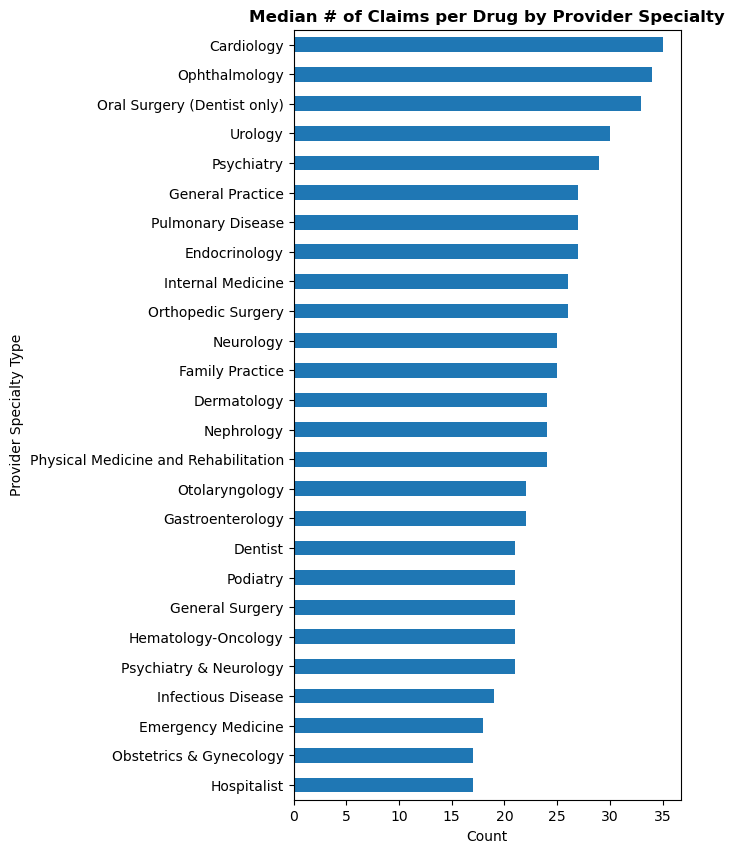

In [83]:
fig17_data = df2.groupby(["Prscrbr_Type"])["Tot_Clms"].median().sort_values(ascending=True)

plt.figure(figsize=(5,10))
fig17_data.plot.barh()
plt.xlabel('Count')
plt.ylabel('Provider Specialty Type')
plt.title('Median # of Claims per Drug by Provider Specialty',fontweight='bold')
plt.savefig('Figure 17 - Median # of Claims per Drug by Provider Specialty.png', dpi=1200,bbox_inches="tight")
plt.show()


In [84]:
df3 = df2[(df2["Prscrbr_Type"] == 'Cardiology') |
          (df2["Prscrbr_Type"] == 'Ophthalmology') |
          (df2["Prscrbr_Type"] == 'Oral Surgery (Dentist only)')|
          (df2["Prscrbr_Type"] == 'Emergency Medicine')|
          (df2["Prscrbr_Type"] == 'Obstetrics & Gynecology')|
          (df2["Prscrbr_Type"] == 'Hospitalist')]

##### Ridge Plot: Distribution of Total Claims by Specialty (Top and Bottom 3 Median Total Claims)

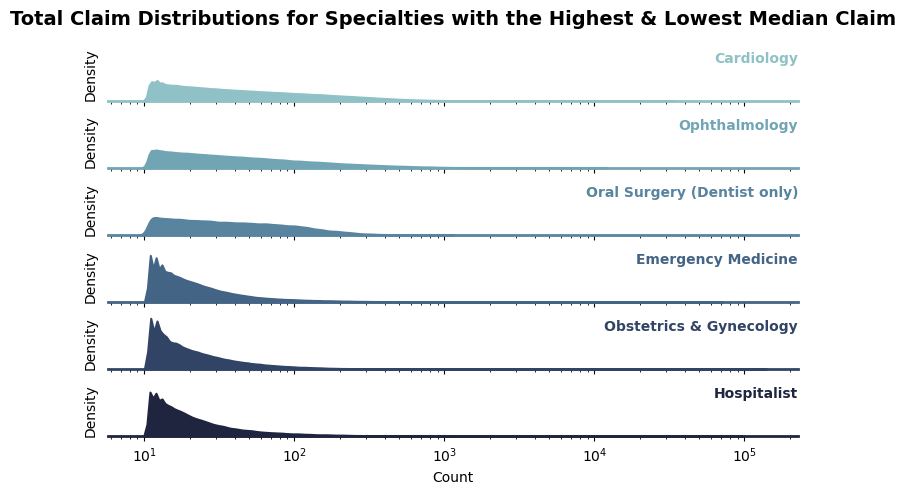

In [101]:
# plot
# Initialize the FacetGrid object

pal = sns.cubehelix_palette(len(df3.Prscrbr_Type.unique()), rot=-.25, light=.7)
g = sns.FacetGrid(df3, row="Prscrbr_Type", hue="Prscrbr_Type", aspect=9, height=0.8, palette=pal, 
                  row_order=["Cardiology", "Ophthalmology", 
                             "Oral Surgery (Dentist only)", 
                             "Emergency Medicine", "Obstetrics & Gynecology", "Hospitalist"],
                 hue_order=["Cardiology", "Ophthalmology", 
                             "Oral Surgery (Dentist only)", 
                             "Emergency Medicine", "Obstetrics & Gynecology", "Hospitalist"])

# Draw the densities in a few steps
g.map(sns.kdeplot, "Tot_Clms", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5,log_scale=True)
#g.map(sns.kdeplot, "Tot_Clms", clip_on=False, color="w", lw=2, bw_adjust=.5,log_scale=True)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(1, 0.8, label, fontweight="bold", color=color, ha="right", va="center", transform=ax.transAxes)

g.map(label, "Prscrbr_Type")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap

g.set(yticks=[])
g.set(xlabel=None)
g.set(ylabel= None)
g.set_titles("")
g.despine(bottom=True, left=True)
g.fig.tight_layout()
g.set_axis_labels("Count", "Density")
g.figure.suptitle("Total Claim Distributions for Specialties with the Highest & Lowest Median Claim", 
                  size=14,fontweight='bold')
g.figure.subplots_adjust(top=.9)
g.savefig("Figure 18 - Ridge Plot for Total Claims.png", dpi=1200,bbox_inches="tight")

<AxesSubplot:xlabel='Tot_Clms', ylabel='Density'>

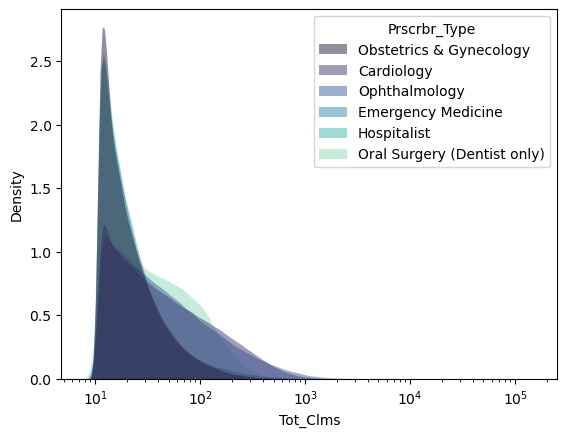

In [86]:
sns.kdeplot(
   data=df3, x="Tot_Clms", hue="Prscrbr_Type",
   fill=True, common_norm=False, palette="mako",
   alpha=.5, linewidth=0,log_scale=True)

##### Distribution of Cost per Claim by Specialty

In [ ]:
categories = fig10_data['Prscrbr_Type'].unique()
bin_range = np.logspace(np.log10(1),np.log10(282651),50)

for c in categories[0:5]:
    plt.hist(fig10_data[fig10_data['Prscrbr_Type']==c]['Cst_per_Clm'],log=True,alpha=0.5,label=c,bins=500,density=True)
plt.legend()
plt.semilogy()
plt.semilogx()
plt.ylabel('fraction')
plt.xlabel('Cst_per_Clm')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='x', y='y', hue='Prscrbr_Type', data=fig10_data) 
plt.show()

##### Aggregate Sum of Drug Claims per Specialty

In [33]:
fig11_data = df2.groupby(["Prscrbr_Type"])["Tot_Clms"].sum().sort_values(ascending=True)

plt.figure(figsize=(5,10))
fig11_data.plot.barh()
plt.xlabel('# of Claims')
plt.ylabel('Provider Specialty Type')

plt.title('Aggregate Sum of Claims by Provider Specialty',fontweight='bold')
plt.savefig('Figure 11 - Aggregate Sum of Claims by Provider Specialty.png', dpi=1200,bbox_inches="tight")
plt.show()


NameError: name 'df2' is not defined

##### Distribution of Drug Claims per Specialty

##### Total Cost vs Total Claim

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(df2.Tot_Clms, df2.Tot_Drug_Cst, s=60, alpha=0.7, edgecolors="k")

ax.set_xscale("log")
ax.set_yscale("log")


plt.title("Total Cost vs Total Claim",fontweight='bold')

plt.xlabel('# of Claims')
plt.ylabel('Total Drug Cost [$]')
plt.savefig('Figure 12 - Total Cost vs Total Claim Scatterplot.png', dpi=1200,bbox_inches="tight")
plt.show()

In [ ]:
fig16_data = df2[(df2["Prscrbr_Type"] == 'Ophthalmology') |
                 (df2["Prscrbr_Type"] == 'Pulmonary Disease') | 
                 (df2["Prscrbr_Type"] == 'Endocrinology') | 
                (df2["Prscrbr_Type"] == 'Emergency Medicine' )|
                (df2["Prscrbr_Type"] == 'Oral Surgery (Dentist only)' )|
                (df2["Prscrbr_Type"] == 'Dentist')]


In [ ]:
hue_order = ["Pulmonary Disease", "Endocrinology", "Ophthalmology",
            "Emergency Medicine", "Oral Surgery (Dentist only)", "Dentist"]

fig, ax = plt.subplots(figsize=(5,5))
g = sns.scatterplot(x='Tot_Clms', y='Tot_Drug_Cst', hue='Prscrbr_Type', 
                    data=fig16_data, palette="coolwarm", hue_order = hue_order)
g.legend(loc='lower right') #, bbox_to_anchor=(1, 0.5), ncol=1

ax.set_xscale("log")
ax.set_yscale("log")

plt.xlabel('# of Claims')
plt.ylabel('Total Drug Cost [$]')

plt.title("Total Drug Cost vs Total # of Claim for Select Specialties",fontweight='bold')
plt.savefig('Figure 13 - Total Cost vs Total Claim for Select Specialties.png', dpi=1200,bbox_inches="tight")

plt.show()

#### Exploring Categorical Features

##### Number of Unique Providers in the Dataset

In [ ]:
uniqueNPIs = df2.Prscrbr_NPI.unique()

print(f'Number of Unique Providers: {len(uniqueNPIs)}')

##### Number of Unique Generic Drugs

In [ ]:
uniqueGenericDrugs = df2.Gnrc_Name.unique()
print(f'Number of unique generic name drugs:{len(uniqueGenericDrugs)}')
#replace rare drugs w/string 'rare' <100

##### Number of Unique Generic Drugs per Specialty

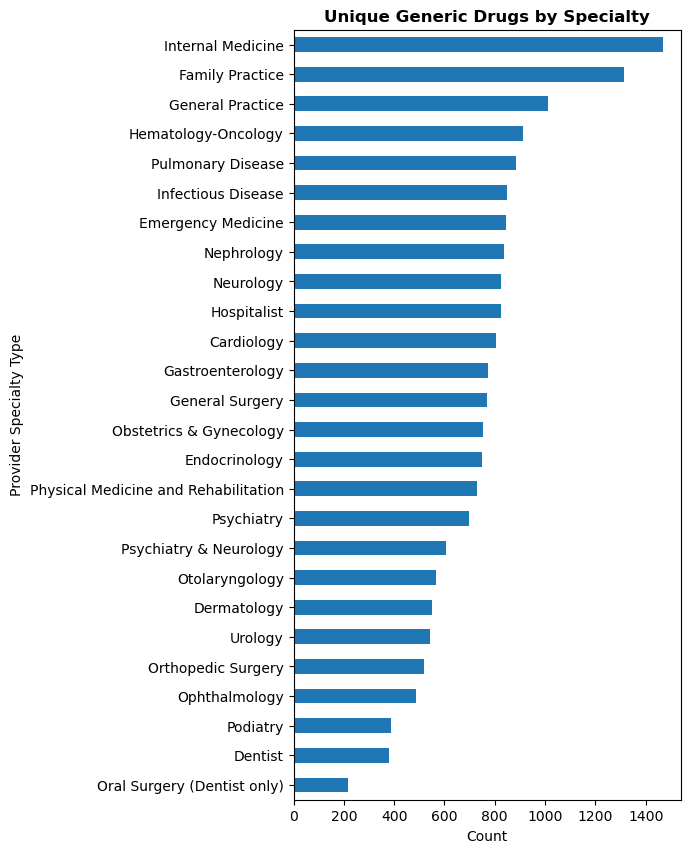

In [184]:
fig14_data = df2.groupby('Prscrbr_Type')['Gnrc_Name'].nunique().sort_values(ascending=True)

plt.figure(figsize=(5,10))
fig14_data.plot.barh()
plt.xlabel('Count')
plt.ylabel('Provider Specialty Type')
plt.title('Unique Generic Drugs by Specialty',fontweight='bold')
plt.savefig('Figure 14 - Unique Generic Drugs by Specialty.png', dpi=1200,bbox_inches="tight")
plt.show()


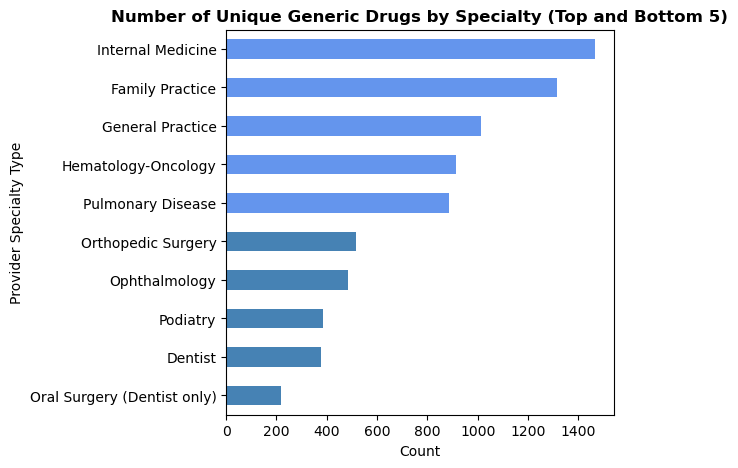

In [185]:

fig15_data = pd.concat([fig14_data.nlargest(5), fig14_data.nsmallest(5)]).sort_values(ascending=True)

plt.figure(figsize=(5,5))

c = ['steelblue','steelblue','steelblue','steelblue','steelblue',
    'cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue']

fig15_data.plot.barh(color = c)

plt.xlabel('Count')
plt.ylabel('Provider Specialty Type')
plt.title('Number of Unique Generic Drugs by Specialty (Top and Bottom 5)',fontweight='bold')
plt.savefig('Figure 15 - Unique Generic Drugs by Specialty (Top and Bottom 5).png', dpi=1200,bbox_inches="tight")
plt.show()

#median drug price per specialty

In [102]:
GenericDrugsCountbyNPI = pd.DataFrame(df2.groupby('Gnrc_Name')['Prscrbr_NPI'].nunique())
GenericDrugsCountbyNPI.reset_index(inplace=True)
GenericDrugsCountbyNPI.columns = ['Generic Name', '# of NPIs']
GenericDrugsCountbyNPI = GenericDrugsCountbyNPI.sort_values(by=['# of NPIs'], ascending=False)

GenericDrugsCountbyNPI.head()

,Generic Name,# of NPIs
125,Atorvastatin Calcium,209903
677,Gabapentin,201973
81,Amlodipine Besylate,198826
914,Lisinopril,191610
1147,Omeprazole,179249


In [103]:
GenericDrugsbyCount_HighFreq = GenericDrugsCountbyNPI[GenericDrugsCountbyNPI['# of NPIs'] >= 250]

GenericDrugsbyCount_HighFreq.head()

print(f"Number of Generic Drugs Prescribed by >= 250 Physicians : {len(GenericDrugsbyCount_HighFreq)}")

Number of Generic Drugs Prescribed by >= 250 Physicians : 857


In [104]:
# Replace "rare drugs" that occur < 250 times with string "Rare"

GenericDrugsbyCount_LowFreq = GenericDrugsCountbyNPI[GenericDrugsCountbyNPI['# of NPIs'] < 250]

print(f"Number of Generic Drugs Prescribed by < 250 Physicians : {len(GenericDrugsbyCount_LowFreq)}")

GenericDrugsbyCount_LowFreqList = list(GenericDrugsbyCount_LowFreq ['Generic Name'])


Number of Generic Drugs Prescribed by < 250 Physicians : 836


In [ ]:
df2.Gnrc_Name = np.where(df2.Gnrc_Name.isin(GenericDrugsbyCount_LowFreqList), "Rare", df2.Gnrc_Name)

In [ ]:
fig11_data = fig10_data.groupby(["Prscrbr_Type"])["Tot_Clms"].sum().sort_values(ascending=True)

plt.figure(figsize=(5,10))
fig11_data.plot.barh()
plt.xlabel('# of Claims')
plt.ylabel('Provider Specialty Type')
plt.title('Aggregate Sum of Claims by Provider Specialty',fontweight='bold')
plt.savefig('Figure 11 - Aggregate Sum of Claims by Provider Specialty.png', dpi=1200,bbox_inches="tight")
plt.show()


##### Number of Unique Brand Name Drugs

In [ ]:
uniqueBrandNameDrugs = df2.Brnd_Name.unique()
print(f'Number of unique brand name drugs: {len(uniqueBrandNameDrugs)}')
print()
df2['Brnd_Name'].value_counts()

In [ ]:
BrandDrugsCountbyNPI = pd.DataFrame(df2.groupby('Brnd_Name')['Prscrbr_NPI'].nunique())
BrandDrugsCountbyNPI.reset_index(inplace=True)
BrandDrugsCountbyNPI.columns = ['Brand Name', '# of NPIs']
BrandDrugsCountbyNPI = BrandDrugsCountbyNPI.sort_values(by=['# of NPIs'], ascending=False)

BrandDrugsCountbyNPI.head()

In [ ]:
BrandDrugsbyCount_HighFreq = BrandDrugsCountbyNPI[BrandDrugsCountbyNPI['# of NPIs'] >= 250]

BrandDrugsbyCount_HighFreq.head()

print(f"Number of Brand Name Drugs Prescribed by >= 250 Physicians : {len(BrandDrugsbyCount_HighFreq)}")

df2.Brnd_Name = np.where(df2.Brnd_Name.isin(BrandDrugsbyCount_LowFreqList), "Rare", df2.Gnrc_Name)

In [ ]:
# Replace "rare drugs" that occur < 250 times with string "Rare"

BrandDrugsbyCount_LowFreq = BrandDrugsCountbyNPI[BrandDrugsCountbyNPI['# of NPIs'] < 250]

print(f"Number of Brand Name Drugs Prescribed by < 250 Physicians : {len(BrandDrugsbyCount_LowFreq)}")

BrandDrugsbyCount_LowFreqList = list(BrandDrugsbyCount_LowFreq ['Brand Name'])

In [ ]:
df2.Brnd_Name = np.where(df2.Brnd_Name.isin(BrandDrugsbyCount_LowFreqList), "Rare", df2.Brnd_Name)

##### City and State of the Provdider

In [ ]:
uniqueStates = df2.Prscrbr_State_Abrvtn.unique()

print(f'Number of unique states: {len(uniqueStates)}')

In [ ]:
print(uniqueStates)

#### Visualizing Features vs Target Variable

##### Average Total Claims by Specialty

In [ ]:
AvgTotClaimsbySpec = pd.DataFrame(df2.groupby('Prscrbr_Type')['Tot_Clms'].mean())
#DrugCostbySpec.reset_index(inplace=True)
AvgTotClaimsbySpec.columns = ['Mean Total Claims']
AvgTotClaimsbySpec = AvgTotClaimsbySpec.sort_values(by=['Mean Total Claims'], ascending=False)

plt.figure(figsize=(5,10))
AvgTotClaimsbySpec.sort_values(by = ['Mean Total Claims'], ascending=True).plot.barh()
plt.xlabel('Count')
plt.ylabel('Provider Specialty Type')
plt.title('Mean Total Claims by Specialty',fontweight='bold')
plt.show()

##### Total Claims per Specialty

In [ ]:
TotClaimsbySpec = pd.DataFrame(df2.groupby('Prscrbr_Type')['Tot_Clms'].sum())
#DrugCostbySpec.reset_index(inplace=True)
TotClaimsbySpec.columns = ['Total Claims']
TotClaimsbySpec = TotClaimsbySpec.sort_values(by=['Total Claims'], ascending=False)

plt.figure(figsize=(5,10))
TotClaimsbySpec.sort_values(by = ['Total Claims'], ascending=True).plot.barh()
plt.xlabel('Count')
plt.ylabel('Provider Specialty Type')
plt.title('Total Claims by Specialty',fontweight='bold')
plt.show()

##### Average Aggregate Drug Cost for All Claims by Specialty

In [ ]:
DrugCostbySpec = pd.DataFrame(df2.groupby('Prscrbr_Type')['Tot_Drug_Cst'].mean())
#DrugCostbySpec.reset_index(inplace=True)
DrugCostbySpec.columns = ['Mean Aggregate Drug Cost']
DrugCostbySpec = DrugCostbySpec.sort_values(by=['Mean Aggregate Drug Cost'], ascending=False)

plt.figure(figsize=(5,10))
DrugCostbySpec.sort_values(by = ['Mean Aggregate Drug Cost'], ascending=True).plot.barh()
plt.xlabel('Cost [$]')
plt.ylabel('Provider Specialty Type')
plt.title('Average Aggregate Drug Cost for All Claims by Specialty',fontweight='bold')
plt.show()

##### 

## II. Splitting Data into Train, Validation, and Test Sets

**- Since multiple rows can fall under the same NPI, Stratified Group KFold will be used on the data to split by NPI.**

##### Check Dataset Dimensions Before Splitting

In [12]:
rows, columns = df2.shape

print(f'Rows: {rows}')
print(f'Columns: {columns}')

Rows: 17972550
Columns: 16


##### Separate Feature and Target Variables

In [115]:
X = df2.drop(['Prscrbr_Type', 'Prscrbr_NPI'], axis=1)

y = df2.Prscrbr_Type

groups = df2.Prscrbr_NPI

print(f'Number of features: {X.shape[1]}')

Number of features: 14


In [14]:
del df2 #Save memory

##### Store Feature Weights in a DataFrame

In [121]:
classes, counts = np.unique(y,return_counts=True)
balance_df = pd.DataFrame({'Classes':classes, 'counts':counts})
balance_df["Raw Data"] = (balance_df["counts"]/len(y))*100
balance_df = balance_df.drop(["counts"], axis=1)

balance_df = balance_df.T

balance_df = balance_df.rename(columns=balance_df.iloc[0])
balance_df = balance_df.iloc[1: , :]
balance_df = balance_df.T
balance_df = balance_df[balance_df.columns].astype(float)

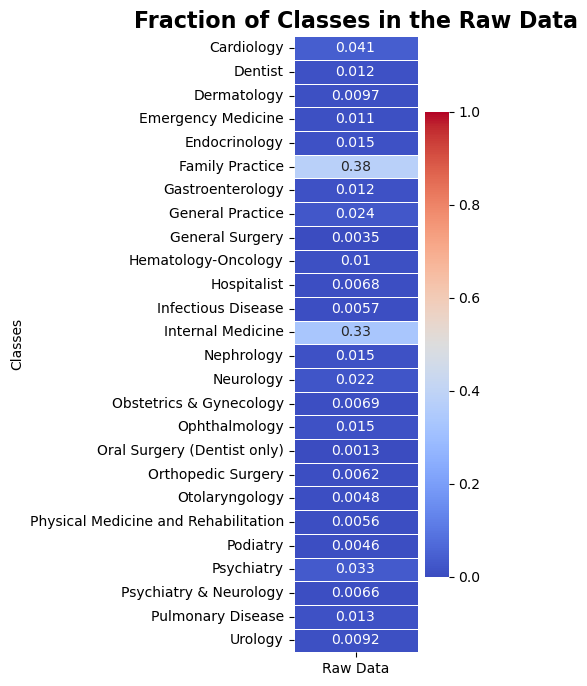

In [124]:
plt.figure(figsize=(2,8))

sns.heatmap((balance_df/100),linewidth=0.5,cmap="coolwarm",vmin=0, vmax=1,annot=True,fmt=".2", cbar_kws={"shrink": .82})
plt.yticks(rotation=0)
plt.ylabel("Classes")
plt.title("Fraction of Classes in the Raw Data",fontweight='bold', fontsize=16)
plt.savefig('Figure 19 - Fraction of Classes in the Raw Data.png', dpi=1200,bbox_inches="tight")

plt.show()

##### Use StratifiedGroupKFold

In [20]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedGroupKFold

np.random.seed(42)

##### Stratified Sampling

To reduce computational cost of preprocessing the data and running an ML model, stratified sampling will be used. 

**The code below will give me 1% of the original dataset but with the same distribution as the raw dataset**

In [24]:
%%time

X_subsample_list = []
y_subsample_list = []
groups_subsample_list = []

stratGroupKFold = StratifiedGroupKFold(n_splits=100)

counter = 0

for i_other,i_test in stratGroupKFold.split(X, y, groups):
    
    counter += 1
    print(f'Fold: {counter}')
    print()
    
    X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
    X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

    #print("Size of OTHER:", len(y_other))
    print("Size of OTHER:", len(y_other))
    print("Size of OTHER:", len(y_other)/len(y))
    print()

    #print("Size of TEST:", len(y_test))
    print("Size of TEST:", len(y_test))
    print("Size of TEST:", len(y_test)/len(y))
    
X_subsample = pd.DataFrame(X_test)
y_subsample = pd.DataFrame(y_test)
groups_subsample = pd.DataFrame(groups_test)

Fold: 1
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792827
Size of OTHER: 0.9900001391010179

Size of TEST: 179723
Size of TEST: 0.009999860898982058
Fold: 2
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792827
Size of OTHER: 0.9900001391010179

Size of TEST: 179723
Size of TEST: 0.009999860898982058
Fold: 3
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792827
Size of OTHER: 0.9900001391010179

Size of TEST: 179723
Size of TEST: 0.009999860898982058
Fold: 4
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792827
Size of OTHER: 0.9900001391010179

Size of TEST: 179723
Size of TEST: 0.009999860898982058
Fold: 5
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792827
Size of OTHER: 0.9900001391010179

Size of TEST: 179723
Size of TEST: 0.009999860898982058
Fold: 6
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792828
Size of OTHER: 0.9900001947414251

Size of TEST: 179722
Size of T

Fold: 49
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792826
Size of OTHER: 0.9900000834606107

Size of TEST: 179724
Size of TEST: 0.009999916539389236
Fold: 50
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792826
Size of OTHER: 0.9900000834606107

Size of TEST: 179724
Size of TEST: 0.009999916539389236
Fold: 51
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792826
Size of OTHER: 0.9900000834606107

Size of TEST: 179724
Size of TEST: 0.009999916539389236
Fold: 52
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792827
Size of OTHER: 0.9900001391010179

Size of TEST: 179723
Size of TEST: 0.009999860898982058
Fold: 53
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792827
Size of OTHER: 0.9900001391010179

Size of TEST: 179723
Size of TEST: 0.009999860898982058
Fold: 54
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792826
Size of OTHER: 0.9900000834606107

Size of TEST: 179724
Siz

Fold: 97
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792821
Size of OTHER: 0.9899998052585749

Size of TEST: 179729
Size of TEST: 0.010000194741425118
Fold: 98
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792821
Size of OTHER: 0.9899998052585749

Size of TEST: 179729
Size of TEST: 0.010000194741425118
Fold: 99
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792821
Size of OTHER: 0.9899998052585749

Size of TEST: 179729
Size of TEST: 0.010000194741425118
Fold: 100
*** SUBSAMPLE DATA AND KEEP LAST FOLD ONLY ***

Size of OTHER: 17792821
Size of OTHER: 0.9899998052585749

Size of TEST: 179729
Size of TEST: 0.010000194741425118
CPU times: user 1h 44min 58s, sys: 12min 3s, total: 1h 57min 2s
Wall time: 2h 4min 1s


In [187]:
len(y_subsample)

179729

##### Save subsampled data

##### Verify that subsample has the same distribution as the raw dataset

In [125]:
classes, counts = np.unique(y_subsample,return_counts=True)
balance_subsample = pd.DataFrame({'Classes':classes, 'counts':counts})
balance_subsample["Subsample"] = (balance_subsample["counts"]/len(y_subsample))*100
balance_subsample = balance_subsample.drop(["counts"], axis=1)

balance_subsample = balance_subsample.T

balance_subsample = balance_subsample.rename(columns=balance_subsample.iloc[0])
balance_subsample = balance_subsample.iloc[1: , :]

In [129]:
balance_RawAndSubsample = pd.concat([balance_df, 
                              balance_subsample], axis=0).T
#balance_RawAndSubsample = balance_RawAndSubsample.reset_index(level=0)


In [128]:
balance_df = balance_df.T
balance_RawAndSubsample = balance_RawAndSubsample[balance_RawAndSubsample.columns].astype(float)

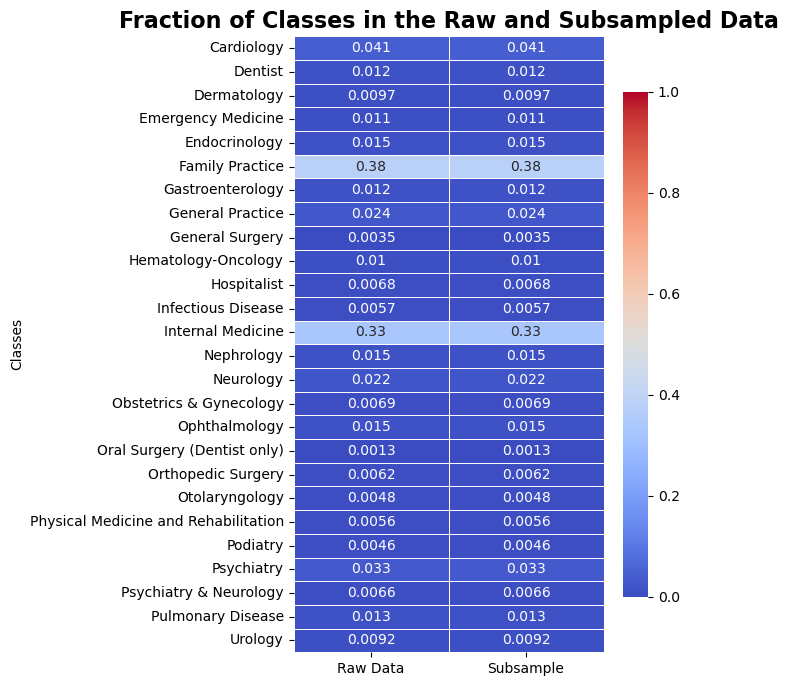

In [186]:
plt.figure(figsize=(5,8))

sns.heatmap((balance_RawAndSubsample/100),linewidth=0.5,cmap="coolwarm",vmin=0, vmax=1,annot=True,fmt=".2", cbar_kws={"shrink": .82})
plt.yticks(rotation=0)
plt.ylabel("Classes")
plt.title("Fraction of Classes in the Raw and Subsampled Data",fontweight='bold', fontsize=16)
plt.savefig('Figure 16 - Fraction of Classes in the Raw and Subsampled Data 2.png', dpi=1200,bbox_inches="tight")

plt.show()

#### Data Splitting + Preprocessing

In [200]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

categorical_ftrs = ['Prscrbr_City',
                    'Prscrbr_State_Abrvtn',
                    'Brnd_Name',
                    'Gnrc_Name']

std_ftrs = ['Tot_Clms', 
            'Tot_30day_Fills', 
            'Tot_Day_Suply', 
            'Tot_Drug_Cst', 
            'Tot_Benes', 
            'GE65_Tot_Clms',
            'GE65_Tot_30day_Fills',
            'GE65_Tot_Drug_Cst',
            'GE65_Tot_Day_Suply',
            'GE65_Tot_Benes']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), categorical_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])                                               


###### 80-10-10 Split

In [161]:
%%time

y_train_list = []
y_validation_list = []
y_test_list = []

stratGroupKFold = StratifiedGroupKFold(n_splits=10)
stratGroupKFold2 = StratifiedGroupKFold(n_splits=9)

counter = 0

for i_other,i_test in stratGroupKFold.split(X_subsample, y_subsample, groups_subsample):
    counter += 1
    print(f'Fold: {counter}')
    print()
    
    X_other, y_other, groups_other = X_subsample.iloc[i_other], y_subsample.iloc[i_other], groups_subsample.iloc[i_other]
    X_test, y_test, groups_test = X_subsample.iloc[i_test], y_subsample.iloc[i_test], groups_subsample.iloc[i_test]
    
    y_test_list.append(y_test)
    
    #print("Size of OTHER:", len(y_other))
    print("% OTHER:", len(y_other)/len(y_subsample))
    print()

    #m("Size of TEST:", len(y_test))
    print("% TEST:", len(y_test)/len(y_subsample))
    print()

    
    for i_train, i_validation in stratGroupKFold2.split(X_other, y_other, groups_other):
    
        X_train, y_train, groups_train = X_other.iloc[i_train], y_other.iloc[i_train], groups_other.iloc[i_train]
        X_validation, y_validation , groups_validation = X_other.iloc[i_validation], y_other.iloc[i_validation], groups_other.iloc[i_validation]
        
        y_train_list.append(y_train)
        y_validation_list.append(y_validation)
        
        print("% TRAIN:", len(y_train)/len(y_subsample))
        print()

        print("% VALIDATION:", len(y_validation)/len(y_subsample))
        print()
        
        X_train_prep = clf.fit_transform(X_train)
        print(f"X_train shape: {X_train.shape}")
        print(f"X_train_prep shape: {X_train_prep.shape}")
        print()
              
        X_val_prep = clf.transform(X_validation)
        print(f"X_val shape: {X_validation.shape}")
        print(f"X_val shape: {X_val_prep.shape}")
        print()
              
        X_test_prep = clf.transform(X_test)
        print(f"X_test shape: {X_test.shape}")
        print(f"X_test_prep shape: {X_test_prep.shape}")
        print()

NameError: name 'StratifiedGroupKFold' is not defined

In [198]:
X_val_prep = clf.transform(X_validation)
print(X_validation.shape)
print(X_val_prep.shape)

(35945, 14)
(35945, 4178)


In [197]:
X_test_prep = clf.transform(X_test)
print(X_test.shape)
print(X_test_prep.shape)

(35945, 14)
(35945, 4178)


In [191]:
print(X_train.shape)
print(X_train_prep.shape)

(107839, 14)
(107839, 4178)


##### Checking distribution of classes for each set

In [106]:
classes_test, count_test = np.unique(y_test,return_counts=True)
classes_train, count_train = np.unique(y_train,return_counts=True)
classes_val, count_val = np.unique(y_validation,return_counts=True)


balance_df_test =pd.DataFrame({'Classes':classes_test, 'counts':count_test})
balance_df_train =pd.DataFrame({'Classes':classes_train, 'counts':count_train})
balance_df_val =pd.DataFrame({'Classes':classes_val, 'counts':count_val})

balance_df_test["Test Set"] = (balance_df_test["counts"]/len(y_test))*100
balance_df_train["Train Set"] = (balance_df_train["counts"]/len(y_train))*100
balance_df_val["Validation Set"] = (balance_df_val["counts"]/len(y_validation))*100

balance_df_test= balance_df_test.drop(["counts"], axis=1)
balance_df_train= balance_df_train.drop(["counts"], axis=1)
balance_df_val= balance_df_val.drop(["counts"], axis=1)

balance_df_test = balance_df_test.T
balance_df_train = balance_df_train.T
balance_df_val = balance_df_val.T

balance_df_test = balance_df_test.rename(columns=balance_df_test.iloc[0])
balance_df_test = balance_df_test.iloc[1: , :]
balance_df_train = balance_df_train.rename(columns=balance_df_train.iloc[0])
balance_df_train = balance_df_train.iloc[1: , :]
balance_df_val = balance_df_val.rename(columns=balance_df_val.iloc[0])
balance_df_val = balance_df_val.iloc[1: , :]


balance_allSets = pd.concat([balance_df, balance_df_test,balance_df_train,balance_df_val], axis=0)

In [127]:
balance_allSets.sum(axis=1)

Raw Data          100.0
Test Set          100.0
Train Set         100.0
Validation Set    100.0
dtype: float64

##### Checking Distribution of each CV Fold

In [124]:
y_train_CV1 = y_train_list[0]
y_train_CV2 = y_train_list[1]
y_train_CV3 = y_train_list[2]
y_train_CV4 = y_train_list[3]
y_train_CV5 = y_train_list[4]
y_train_CV6 = y_train_list[5]
y_train_CV7 = y_train_list[6]
y_train_CV8 = y_train_list[7]
y_train_CV9 = y_train_list[8]

y_validation_list_CV1 = y_validation_list[0]
y_validation_list_CV2 = y_validation_list[1]
y_validation_list_CV3 = y_validation_list[2]
y_validation_list_CV4 = y_validation_list[3]
y_validation_list_CV5 = y_validation_list[4]
y_validation_list_CV6 = y_validation_list[5]
y_validation_list_CV7 = y_validation_list[6]
y_validation_list_CV8 = y_validation_list[7]
y_validation_list_CV9 = y_validation_list[8]

classes_train_CV1, count_train_CV1 = np.unique(y_train_CV1,return_counts=True)
classes_train_CV2, count_train_CV2 = np.unique(y_train_CV2,return_counts=True)
classes_train_CV3, count_train_CV3 = np.unique(y_train_CV3,return_counts=True)
classes_train_CV4, count_train_CV4 = np.unique(y_train_CV4,return_counts=True)
classes_train_CV5, count_train_CV5 = np.unique(y_train_CV5,return_counts=True)
classes_train_CV6, count_train_CV6 = np.unique(y_train_CV6,return_counts=True)
classes_train_CV7, count_train_CV7 = np.unique(y_train_CV7,return_counts=True)
classes_train_CV8, count_train_CV8 = np.unique(y_train_CV8,return_counts=True)
classes_train_CV9, count_train_CV9 = np.unique(y_train_CV9,return_counts=True)

balance_df_train_CV1 =pd.DataFrame({'Classes':classes_train_CV1, 'counts':count_train_CV1})
balance_df_train_CV2 =pd.DataFrame({'Classes':classes_train_CV2, 'counts':count_train_CV2})
balance_df_train_CV3 =pd.DataFrame({'Classes':classes_train_CV3, 'counts':count_train_CV3})
balance_df_train_CV4 =pd.DataFrame({'Classes':classes_train_CV4, 'counts':count_train_CV4})
balance_df_train_CV5 =pd.DataFrame({'Classes':classes_train_CV5, 'counts':count_train_CV5})
balance_df_train_CV6 =pd.DataFrame({'Classes':classes_train_CV6, 'counts':count_train_CV6})
balance_df_train_CV7 =pd.DataFrame({'Classes':classes_train_CV7, 'counts':count_train_CV7})
balance_df_train_CV8 =pd.DataFrame({'Classes':classes_train_CV8, 'counts':count_train_CV8})
balance_df_train_CV9 =pd.DataFrame({'Classes':classes_train_CV9, 'counts':count_train_CV9})

balance_df_train_CV1["Train Set Fold 1"] = (balance_df_train_CV1["counts"]/len(y_train_CV1))*100
balance_df_train_CV2["Train Set Fold 2"] = (balance_df_train_CV2["counts"]/len(y_train_CV2))*100
balance_df_train_CV3["Train Set Fold 3"] = (balance_df_train_CV3["counts"]/len(y_train_CV3))*100
balance_df_train_CV4["Train Set Fold 4"] = (balance_df_train_CV4["counts"]/len(y_train_CV4))*100
balance_df_train_CV5["Train Set Fold 5"] = (balance_df_train_CV5["counts"]/len(y_train_CV5))*100
balance_df_train_CV6["Train Set Fold 6"] = (balance_df_train_CV6["counts"]/len(y_train_CV6))*100
balance_df_train_CV7["Train Set Fold 7"] = (balance_df_train_CV7["counts"]/len(y_train_CV7))*100
balance_df_train_CV8["Train Set Fold 8"] = (balance_df_train_CV8["counts"]/len(y_train_CV8))*100
balance_df_train_CV9["Train Set Fold 9"] = (balance_df_train_CV9["counts"]/len(y_train_CV9))*100

balance_df_train_CV1= balance_df_train_CV1.drop(["counts"], axis=1)
balance_df_train_CV2= balance_df_train_CV2.drop(["counts"], axis=1)
balance_df_train_CV3= balance_df_train_CV3.drop(["counts"], axis=1)
balance_df_train_CV4= balance_df_train_CV4.drop(["counts"], axis=1)
balance_df_train_CV5= balance_df_train_CV5.drop(["counts"], axis=1)
balance_df_train_CV6= balance_df_train_CV6.drop(["counts"], axis=1)
balance_df_train_CV7= balance_df_train_CV7.drop(["counts"], axis=1)
balance_df_train_CV8= balance_df_train_CV8.drop(["counts"], axis=1)
balance_df_train_CV9= balance_df_train_CV9.drop(["counts"], axis=1)

balance_df_train_CV1= balance_df_train_CV1.T
balance_df_train_CV2= balance_df_train_CV2.T
balance_df_train_CV3= balance_df_train_CV3.T
balance_df_train_CV4= balance_df_train_CV4.T
balance_df_train_CV5= balance_df_train_CV5.T
balance_df_train_CV6= balance_df_train_CV6.T
balance_df_train_CV7= balance_df_train_CV7.T
balance_df_train_CV8= balance_df_train_CV8.T
balance_df_train_CV9= balance_df_train_CV9.T

balance_df_train_CV1 = balance_df_train_CV1.rename(columns=balance_df_train_CV1[0])
balance_df_train_CV2 = balance_df_train_CV2.rename(columns=balance_df_train_CV2[0])
balance_df_train_CV3 = balance_df_train_CV3.rename(columns=balance_df_train_CV3[0])
balance_df_train_CV4 = balance_df_train_CV4.rename(columns=balance_df_train_CV4[0])
balance_df_train_CV5 = balance_df_train_CV5.rename(columns=balance_df_train_CV5[0])
balance_df_train_CV6 = balance_df_train_CV6.rename(columns=balance_df_train_CV6[0])
balance_df_train_CV7 = balance_df_train_CV7.rename(columns=balance_df_train_CV7[0])
balance_df_train_CV8 = balance_df_train_CV8.rename(columns=balance_df_train_CV8[0])
balance_df_train_CV9 = balance_df_train_CV9.rename(columns=balance_df_train_CV9[0])

balance_df_train_CV1 = balance_df_train_CV1.iloc[1: , :]
balance_df_train_CV2 = balance_df_train_CV2.iloc[1: , :]
balance_df_train_CV3 = balance_df_train_CV3.iloc[1: , :]
balance_df_train_CV4 = balance_df_train_CV4.iloc[1: , :]
balance_df_train_CV5 = balance_df_train_CV5.iloc[1: , :]
balance_df_train_CV6 = balance_df_train_CV6.iloc[1: , :]
balance_df_train_CV7 = balance_df_train_CV7.iloc[1: , :]
balance_df_train_CV8 = balance_df_train_CV8.iloc[1: , :]
balance_df_train_CV9 = balance_df_train_CV9.iloc[1: , :]


balance_allTrain = pd.concat([balance_df_train_CV1, 
                              balance_df_train_CV2,
                             balance_df_train_CV3,
                             balance_df_train_CV4,
                             balance_df_train_CV5,
                             balance_df_train_CV6,
                             balance_df_train_CV7,
                             balance_df_train_CV8,
                             balance_df_train_CV9], axis=0)

In [125]:
balance_allTrain

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
Train Set Fold 1,4.112097,1.187853,0.970167,1.133381,1.511089,37.630043,1.217454,2.38641,0.35349,1.012245,...,1.517536,0.130512,0.620105,0.482952,0.559506,0.458428,3.325648,0.661537,1.312926,0.917023
Train Set Fold 2,4.112097,1.187846,0.97016,1.133381,1.511096,37.630036,1.217447,2.38641,0.353497,1.012238,...,1.517536,0.130512,0.620105,0.482952,0.559506,0.458428,3.325648,0.661537,1.312933,0.91703
Train Set Fold 3,4.112097,1.187846,0.970167,1.133381,1.511096,37.630032,1.217447,2.38641,0.353497,1.012238,...,1.517536,0.130518,0.620112,0.482952,0.559506,0.458428,3.325648,0.661537,1.312926,0.917023
Train Set Fold 4,4.112097,1.187853,0.970167,1.133381,1.511096,37.630036,1.217447,2.38641,0.353497,1.012238,...,1.517536,0.130512,0.620105,0.482952,0.559506,0.458428,3.325648,0.661537,1.312926,0.91703
Train Set Fold 5,4.112104,1.187846,0.970167,1.133381,1.511096,37.630029,1.217447,2.38641,0.353497,1.012238,...,1.517536,0.130512,0.620105,0.482952,0.559506,0.458428,3.325655,0.661537,1.312926,0.91703
Train Set Fold 6,4.112097,1.187853,0.970167,1.133388,1.511096,37.630029,1.217454,2.38641,0.35349,1.012245,...,1.517536,0.130512,0.620105,0.482952,0.559506,0.458428,3.325655,0.661544,1.312926,0.91703
Train Set Fold 7,4.112097,1.187846,0.97016,1.133388,1.511089,37.630029,1.217454,2.38641,0.353497,1.012238,...,1.517536,0.130518,0.620105,0.482952,0.559506,0.458428,3.325655,0.661544,1.312933,0.917023
Train Set Fold 8,4.112097,1.187846,0.970167,1.133381,1.511096,37.630022,1.217447,2.38641,0.353497,1.012245,...,1.517536,0.130512,0.620105,0.482959,0.559513,0.458421,3.325655,0.661544,1.312926,0.91703
Train Set Fold 9,4.112097,1.187846,0.97016,1.133381,1.511096,37.630029,1.217447,2.386417,0.353497,1.012245,...,1.517536,0.130518,0.620105,0.482952,0.559513,0.458428,3.325655,0.661544,1.312933,0.91703


## III. Data Pre-Processing

#### Handling NaN Values in Categorical Variables

No missing values/NaN in any categorical features

#### Handling NaN Values in Continuous Variables

* Tot_Benes
* GE65_Tot_Clms
* GE65_Tot_30day_Fills
* GE65_Tot_Drug_cst
* GE65_Tot_Day_Suply
* GE65_Tot_Benes

We will leave this as NaN. We can use a better imputation method than mean and median imputations in the future or we can use a model like XGBoost that can handle missing values.

#### Standard Scaler for Continuous Features
* Tot_Clms 
* Tot_30day_Fills
* Tot_Day_Suply
* Tot_Drug_Cst
* Tot_Benes
* GE65_Tot_Clms
* GE65_Tot_30day_Fills
* GE65_Tot_Drug_cst
* GE65_Tot_Day_Suply
* GE65_Tot_Benes

In [17]:
std_ftrs = ['Tot_Clms', 
            'Tot_30day_Fills', 
            'Tot_Day_Suply', 
            'Tot_Drug_Cst', 
            'Tot_Benes', 
            'GE65_Tot_Clms',
            'GE65_Tot_30day_Fills',
            'GE65_Tot_Drug_Cst',
            'GE65_Tot_Day_Suply',
            'GE65_Tot_Benes']

#### Ordinal Encoding for Oridinal Features

This dataset has no ordinal features.

#### One-Hot Encoding for Categorical Variables
* Prscrbr_City
* Prscrbr_State_Abrvtn
* Brnd_Name
* Gnrc_Name

In [14]:
categorical_ftrs = ['Prscrbr_City',
                    'Prscrbr_State_Abrvtn',
                    'Brnd_Name',
                    'Gnrc_Name']

std_ftrs = ['Tot_Clms', 
            'Tot_30day_Fills', 
            'Tot_Day_Suply', 
            'Tot_Drug_Cst', 
            'Tot_Benes', 
            'GE65_Tot_Clms',
            'GE65_Tot_30day_Fills',
            'GE65_Tot_Drug_Cst',
            'GE65_Tot_Day_Suply',
            'GE65_Tot_Benes']

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), categorical_ftrs),
        ('std', StandardScaler(), std_ftrs)])

NameError: name 'std_ftrs' is not defined

#### Unused Code; Do Not Run